# Reddit Sentiment Analysis for ETF Market Prediction

This notebook demonstrates how to scrape Reddit data for sentiment analysis to predict ETF movements in different sectors:
- **Tech Sector**: QQQ (Nasdaq-100), VTI (Total Stock Market)
- **Industrials**: DIA (Dow Jones Industrial Average)
- **Consumer Discretionary**: IWM (Russell 2000), EFA (EAFE)

## Setup and Authentication


In [1]:
# Install required packages (run this cell first if packages are not installed)
# !pip install praw pandas numpy matplotlib seaborn textblob vaderSentiment

import praw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Reddit API Setup

To use this notebook, you'll need to create a Reddit app:
1. Go to https://www.reddit.com/prefs/apps
2. Click "Create App" or "Create Another App"
3. Choose "script" as the app type
4. Fill in the required fields and create the app
5. Note down your client_id, client_secret, and user_agent


In [2]:
# Reddit API credentials - Replace with your actual credentials
CLIENT_ID = "x6_wNje4h80DiBvs-Ly6Kw"
CLIENT_SECRET = "PTk8OvQaUcyyq9n0QUhWD9PnpqrgKA"
USER_AGENT = "ETF_Sentiment_Analysis_Bot/1.0"

# Initialize Reddit instance (read-only mode - no username/password needed)
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# Test connection
try:
    print(f"Reddit instance created successfully!")
    print(f"Read-only mode: {reddit.read_only}")
    
    # Test with a simple API call
    test_subreddit = reddit.subreddit('test')
    print(f"✓ Connection test successful!")
    
except Exception as e:
    print(f"✗ Connection failed: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Make sure CLIENT_ID and CLIENT_SECRET are correct")
    print("2. Verify your Reddit app is type 'script'")
    print("3. Check that your app is not suspended")


Reddit instance created successfully!
Read-only mode: True
✓ Connection test successful!


## ETF and Sector Configuration - creating configurations that store keywords for each ETF that can be used to search for news about that ETF


In [3]:
# Define QQQ ETF configuration for scraping
ETF_CONFIG = {
    'QQQ': {
        'name': 'Invesco QQQ Trust (Nasdaq-100)',
        'sector': 'Technology',
        'keywords': ['QQQ', 'NASDAQ', 'tech stocks', 'technology', 'FAANG', 
                    'Apple', 'Microsoft', 'Amazon', 'Google', 'Meta', 
                    'Nvidia', 'Tesla', 'semiconductor', 'AI', 'tech sector'],
        'subreddits': ['investing', 'stocks', 'wallstreetbets', 
                       'StockMarket', 'options', 'SecurityAnalysis', 
                       'ValueInvesting', 'technews', 'technology']
    }
}

In [4]:
# Load technical dataset to get date range for scraping
technical_data = pd.read_csv('../data/QQQ_Historical_DayByDay.csv')
technical_data['Date'] = pd.to_datetime(technical_data['Date'])

# Get date range
start_date = technical_data['Date'].min()
end_date = technical_data['Date'].max()

print(f"Technical data date range: {start_date.date()} to {end_date.date()}")
print(f"Number of trading days: {len(technical_data)}")

Technical data date range: 2023-11-03 to 2025-11-03
Number of trading days: 501


In [5]:
# Function to scrape Reddit data for QQQ
def scrape_reddit_sentiment(etf_symbol='QQQ', days_to_scrape=30):
    config = ETF_CONFIG[etf_symbol]
    posts_data = []
    comments_data = []
    
    # Calculate the date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_to_scrape)
    
    for subreddit_name in config['subreddits']:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            
            # Search for posts containing keywords
            for keyword in config['keywords']:
                search_query = f'{keyword} AND (flair:DD OR flair:Discussion OR flair:News)'
                
                for post in subreddit.search(search_query, limit=100, sort='new'):
                    post_date = datetime.fromtimestamp(post.created_utc)
                    
                    if start_date <= post_date <= end_date:
                        # Store post data
                        posts_data.append({
                            'date': post_date,
                            'subreddit': subreddit_name,
                            'title': post.title,
                            'text': post.selftext,
                            'score': post.score,
                            'num_comments': post.num_comments,
                            'upvote_ratio': post.upvote_ratio,
                            'keyword': keyword
                        })
                        
                        # Get comments
                        post.comments.replace_more(limit=0)
                        for comment in post.comments.list():
                            comment_date = datetime.fromtimestamp(comment.created_utc)
                            if start_date <= comment_date <= end_date:
                                comments_data.append({
                                    'date': comment_date,
                                    'subreddit': subreddit_name,
                                    'text': comment.body,
                                    'score': comment.score,
                                    'post_title': post.title,
                                    'keyword': keyword
                                })
                                
        except Exception as e:
            print(f"Error scraping r/{subreddit_name}: {str(e)}")
            continue
    
    # Convert to DataFrames
    posts_df = pd.DataFrame(posts_data)
    comments_df = pd.DataFrame(comments_data)
    
    # Add sentiment scores using VADER
    analyzer = SentimentIntensityAnalyzer()
    
    def get_sentiment_scores(text):
        if pd.isna(text) or text == '':
            return pd.Series({'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0})
        scores = analyzer.polarity_scores(text)
        return pd.Series(scores)
    
    # Calculate sentiment for posts (title + text)
    posts_sentiment = posts_df.apply(lambda x: get_sentiment_scores(x['title'] + ' ' + str(x['text'])), axis=1)
    posts_df = pd.concat([posts_df, posts_sentiment], axis=1)
    
    # Calculate sentiment for comments
    comments_sentiment = comments_df['text'].apply(get_sentiment_scores)
    comments_df = pd.concat([comments_df, comments_sentiment], axis=1)
    
    return posts_df, comments_df

# Function to aggregate sentiment by date
def aggregate_daily_sentiment(posts_df, comments_df):
    # Ensure date column is datetime
    posts_df['date'] = pd.to_datetime(posts_df['date'])
    comments_df['date'] = pd.to_datetime(comments_df['date'])
    
    # Round to nearest day
    posts_df['date'] = posts_df['date'].dt.date
    comments_df['date'] = comments_df['date'].dt.date
    
    # Aggregate posts sentiment
    daily_posts = posts_df.groupby('date').agg({
        'compound': ['mean', 'std', 'count'],
        'pos': 'mean',
        'neg': 'mean',
        'score': 'sum',
        'num_comments': 'sum'
    }).round(4)
    
    # Aggregate comments sentiment
    daily_comments = comments_df.groupby('date').agg({
        'compound': ['mean', 'std', 'count'],
        'pos': 'mean',
        'neg': 'mean',
        'score': 'sum'
    }).round(4)
    
    # Rename columns for clarity
    daily_posts.columns = ['post_sentiment_mean', 'post_sentiment_std', 'post_count',
                          'post_positive', 'post_negative', 'total_post_score', 'total_comments']
    daily_comments.columns = ['comment_sentiment_mean', 'comment_sentiment_std', 'comment_count',
                            'comment_positive', 'comment_negative', 'total_comment_score']
    
    # Combine posts and comments data
    daily_sentiment = pd.merge(daily_posts, daily_comments,
                             left_index=True, right_index=True,
                             how='outer').fillna(0)
    
    return daily_sentiment

# Scraping and Processing Data

Let's execute our data collection and processing in three steps:
1. Scrape Reddit data
2. Aggregate daily sentiment
3. Merge with technical data

In [ ]:
# Step 1: Scrape Reddit data
print("Starting Reddit data scraping...")
days_to_scrape = 30  # Adjust this based on your needs
posts_df, comments_df = scrape_reddit_sentiment('QQQ', days_to_scrape)
print(f"Scraped {len(posts_df)} posts and {len(comments_df)} comments")

In [ ]:
# Step 2: Aggregate daily sentiment
print("Aggregating daily sentiment...")
daily_sentiment = aggregate_daily_sentiment(posts_df, comments_df)
print(f"Created daily sentiment summary with {len(daily_sentiment)} days of data")

In [ ]:
# Step 3: Load and merge with technical data
print("Loading technical data and merging...")

# Load technical dataset
technical_data = pd.read_csv('../data/QQQ_Historical_DayByDay.csv')
technical_data['Date'] = pd.to_datetime(technical_data['Date'], utc=True).dt.tz_localize(None)
technical_data.set_index('Date', inplace=True)

# Convert daily_sentiment index to datetime without timezone
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)

# Merge with technical data
merged_data = pd.merge(technical_data, daily_sentiment,
                      left_index=True, right_index=True,
                      how='left')

# Fill missing sentiment values with 0
sentiment_columns = daily_sentiment.columns
merged_data[sentiment_columns] = merged_data[sentiment_columns].fillna(0)

# Save the merged dataset
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = f'QQQ_technical_and_sentiment_{timestamp}.csv'
merged_data.to_csv(output_file)

print("\nFinal dataset summary:")
print(f"Technical data shape: {technical_data.shape}")
print(f"Sentiment data shape: {daily_sentiment.shape}")
print(f"Merged data shape: {merged_data.shape}")
print(f"\nSaved to: {output_file}")
print("\nSample of sentiment columns:")
print(merged_data[sentiment_columns].head())

In [6]:
# Load technical dataset and prepare dates
technical_data = pd.read_csv('../data/QQQ_Historical_DayByDay.csv')
technical_data['Date'] = pd.to_datetime(technical_data['Date'], utc=True).dt.tz_localize(None)
technical_data.set_index('Date', inplace=True)

# Convert timezone-aware dates to UTC, then remove timezone
posts_df['date'] = pd.to_datetime(posts_df['date'], utc=True).dt.tz_localize(None)
comments_df['date'] = pd.to_datetime(comments_df['date'], utc=True).dt.tz_localize(None)

# Aggregate posts sentiment
daily_posts = posts_df.groupby('date').agg({
    'compound': ['mean', 'std', 'count'],
    'pos': 'mean',
    'neg': 'mean',
    'score': 'sum',
    'num_comments': 'sum'
}).round(4)

# Aggregate comments sentiment
daily_comments = comments_df.groupby('date').agg({
    'compound': ['mean', 'std', 'count'],
    'pos': 'mean',
    'neg': 'mean',
    'score': 'sum'
}).round(4)

# Rename columns for clarity
daily_posts.columns = ['post_sentiment_mean', 'post_sentiment_std', 'post_count',
                      'post_positive', 'post_negative', 'total_post_score', 'total_comments']
daily_comments.columns = ['comment_sentiment_mean', 'comment_sentiment_std', 'comment_count',
                         'comment_positive', 'comment_negative', 'total_comment_score']

# Combine posts and comments data
daily_sentiment = pd.merge(daily_posts, daily_comments,
                         left_index=True, right_index=True,
                         how='outer').fillna(0)

# Merge with technical data
merged_data = pd.merge(technical_data, daily_sentiment,
                      left_index=True, right_index=True,
                      how='left')

# Fill missing sentiment values with 0
sentiment_columns = daily_sentiment.columns
merged_data[sentiment_columns] = merged_data[sentiment_columns].fillna(0)

# Save the merged dataset
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
merged_data.to_csv(f'QQQ_technical_and_sentiment_{timestamp}.csv')

print("Data merge completed successfully!")
print(f"Technical data shape: {technical_data.shape}")
print(f"Sentiment data shape: {daily_sentiment.shape}")
print(f"Final merged data shape: {merged_data.shape}")
print("\nSample of sentiment columns:")
print(merged_data[sentiment_columns].head())

NameError: name 'posts_df' is not defined

In [ ]:
# First scrape Reddit data
print("Starting Reddit data scraping...")
days_to_scrape = 30  # Adjust this based on your needs
posts_df, comments_df = scrape_reddit_sentiment('QQQ', days_to_scrape)
print(f"Scraped {len(posts_df)} posts and {len(comments_df)} comments")

In [ ]:
# Now process dates and merge data
# Load technical dataset and prepare dates
technical_data = pd.read_csv('../data/QQQ_Historical_DayByDay.csv')
technical_data['Date'] = pd.to_datetime(technical_data['Date'], utc=True).dt.tz_localize(None)
technical_data.set_index('Date', inplace=True)

# Convert timezone-aware dates to UTC, then remove timezone
posts_df['date'] = pd.to_datetime(posts_df['date'], utc=True).dt.tz_localize(None)
comments_df['date'] = pd.to_datetime(comments_df['date'], utc=True).dt.tz_localize(None)

# Aggregate posts sentiment
daily_posts = posts_df.groupby('date').agg({
    'compound': ['mean', 'std', 'count'],
    'pos': 'mean',
    'neg': 'mean',
    'score': 'sum',
    'num_comments': 'sum'
}).round(4)

# Aggregate comments sentiment
daily_comments = comments_df.groupby('date').agg({
    'compound': ['mean', 'std', 'count'],
    'pos': 'mean',
    'neg': 'mean',
    'score': 'sum'
}).round(4)

# Rename columns for clarity
daily_posts.columns = ['post_sentiment_mean', 'post_sentiment_std', 'post_count',
                      'post_positive', 'post_negative', 'total_post_score', 'total_comments']
daily_comments.columns = ['comment_sentiment_mean', 'comment_sentiment_std', 'comment_count',
                         'comment_positive', 'comment_negative', 'total_comment_score']

# Combine posts and comments data
daily_sentiment = pd.merge(daily_posts, daily_comments,
                         left_index=True, right_index=True,
                         how='outer').fillna(0)

# Merge with technical data
merged_data = pd.merge(technical_data, daily_sentiment,
                      left_index=True, right_index=True,
                      how='left')

# Fill missing sentiment values with 0
sentiment_columns = daily_sentiment.columns
merged_data[sentiment_columns] = merged_data[sentiment_columns].fillna(0)

# Save the merged dataset
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
merged_data.to_csv(f'QQQ_technical_and_sentiment_{timestamp}.csv')

print("Data merge completed successfully!")
print(f"Technical data shape: {technical_data.shape}")
print(f"Sentiment data shape: {daily_sentiment.shape}")
print(f"Final merged data shape: {merged_data.shape}")
print("\nSample of sentiment columns:")
print(merged_data[sentiment_columns].head())

In [ ]:
# Debug: Check what data was scraped
print("Posts DataFrame Info:")
print("-" * 50)
print(f"Number of posts scraped: {len(posts_df)}")
if len(posts_df) > 0:
    print("\nSample post dates:")
    print(posts_df['date'].head())
    print("\nSample sentiment scores:")
    print(posts_df[['compound', 'pos', 'neg']].head())

print("\nComments DataFrame Info:")
print("-" * 50)
print(f"Number of comments scraped: {len(comments_df)}")
if len(comments_df) > 0:
    print("\nSample comment dates:")
    print(comments_df['date'].head())
    print("\nSample sentiment scores:")
    print(comments_df[['compound', 'pos', 'neg']].head())

Posts DataFrame Info:
--------------------------------------------------
Number of posts scraped: 885

Sample post dates:
0    2025-10-28
1    2025-10-24
2    2025-10-14
3    2025-10-12
4    2025-10-08
Name: date, dtype: object

Sample sentiment scores:
   compound    pos    neg
0    0.9899  0.173  0.009
1    0.9672  0.090  0.020
2   -0.0598  0.028  0.039
3   -0.7650  0.091  0.127
4    0.9022  0.118  0.017

Comments DataFrame Info:
--------------------------------------------------
Number of comments scraped: 69653

Sample comment dates:
0    2025-10-28
1    2025-10-28
2    2025-10-28
3    2025-10-28
4    2025-10-29
Name: date, dtype: object

Sample sentiment scores:
   compound    pos    neg
0    0.3612  0.128  0.000
1   -0.6239  0.187  0.418
2    0.6249  0.154  0.000
3    0.5994  0.259  0.000
4   -0.2732  0.131  0.188


In [ ]:
# Fix date alignment and merge data
print("Fixing date alignment and merging data...")

# First, let's check what data we have
print(f"Shape of technical_data: {technical_data.shape}")
print(f"Shape of daily_sentiment: {daily_sentiment.shape}")

# Convert timezone-aware dates to UTC and then remove timezone info
def convert_dates(df):
    if isinstance(df.index, pd.DatetimeIndex):
        if df.index.tz is not None:
            df.index = df.index.tz_convert('UTC').tz_localize(None)
    return df

# Convert both dataframes
technical_data = convert_dates(technical_data)
daily_sentiment = convert_dates(daily_sentiment)

# Ensure both indices are datetime
technical_data.index = pd.to_datetime(technical_data.index)
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)

print("\nDate ranges:")
print(f"Technical data: {technical_data.index.min()} to {technical_data.index.max()}")
print(f"Sentiment data: {daily_sentiment.index.min()} to {daily_sentiment.index.max()}")

# Merge the data
merged_data = technical_data.merge(daily_sentiment,
                                 left_index=True,
                                 right_index=True,
                                 how='left')

# Fill missing sentiment values with 0
sentiment_columns = daily_sentiment.columns
merged_data[sentiment_columns] = merged_data[sentiment_columns].fillna(0)

print("\nShape of merged_data:", merged_data.shape)
print("\nSample of sentiment columns in merged data:")
print(merged_data[sentiment_columns].head())

# Save the merged dataset
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = f'QQQ_technical_and_sentiment_{timestamp}.csv'
merged_data.to_csv(output_file)
print(f"\nSaved merged data to {output_file}")

Number of days with Reddit data: 31

Sample of merged data:
                                 Open        High         Low       Close  \
Date                                                                        
2025-10-28 00:00:00-04:00  630.359985  634.679993  629.250000  632.919983   
2025-10-29 00:00:00-04:00  635.590027  637.010010  630.250000  635.770020   
2025-10-30 00:00:00-04:00  632.169983  633.500000  625.940002  626.049988   
2025-10-31 00:00:00-04:00  634.169983  634.200012  626.690002  629.070007   
2025-11-03 00:00:00-05:00  635.119995  635.820007  629.849976  631.885620   

                             Volume  Dividends  Stock Splits  Capital Gains  \
Date                                                                          
2025-10-28 00:00:00-04:00  61195700        0.0           0.0            0.0   
2025-10-29 00:00:00-04:00  67422800        0.0           0.0            0.0   
2025-10-30 00:00:00-04:00  61628600        0.0           0.0            0.0   
2025-

In [ ]:
# Debug date formats
print("Technical Data index info:")
print(technical_data.index.dtype)
print(technical_data.index[:5])
print("\nIs timezone aware?", technical_data.index.tz is not None)

print("\nDaily Sentiment index info:")
print(daily_sentiment.index.dtype)
print(daily_sentiment.index[:5])
print("\nIs timezone aware?", daily_sentiment.index.tz is not None)

# Convert to pandas Timestamp and handle timezones explicitly
daily_sentiment.index = daily_sentiment.index.map(lambda x: pd.Timestamp(x).tz_localize(None))
technical_data.index = technical_data.index.map(lambda x: pd.Timestamp(x).tz_localize(None))

In [ ]:
# Now merge with naive datetime indices
merged_data = pd.merge(
    technical_data,
    daily_sentiment,
    left_index=True,
    right_index=True,
    how='left'
)

# Fill missing sentiment values with 0
sentiment_columns = daily_sentiment.columns
merged_data[sentiment_columns] = merged_data[sentiment_columns].fillna(0)

print("\nMerged data info:")
print(f"Shape: {merged_data.shape}")
print("\nFirst few rows of sentiment columns:")
print(merged_data[sentiment_columns].head())

# Save the merged dataset
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = f'QQQ_technical_and_sentiment_{timestamp}.csv'
merged_data.to_csv(output_file)
print(f"\nSaved merged data to {output_file}")


Merged data info:
Shape: (501, 36)

First few rows of sentiment columns:
                           post_sentiment_mean  post_sentiment_std  \
Date                                                                 
2023-11-03 00:00:00-04:00                  0.0                 0.0   
2023-11-06 00:00:00-05:00                  0.0                 0.0   
2023-11-07 00:00:00-05:00                  0.0                 0.0   
2023-11-08 00:00:00-05:00                  0.0                 0.0   
2023-11-09 00:00:00-05:00                  0.0                 0.0   

                           post_count  post_positive  post_negative  \
Date                                                                  
2023-11-03 00:00:00-04:00         0.0            0.0            0.0   
2023-11-06 00:00:00-05:00         0.0            0.0            0.0   
2023-11-07 00:00:00-05:00         0.0            0.0            0.0   
2023-11-08 00:00:00-05:00         0.0            0.0            0.0   
2023-11-0

In [ ]:
# Fix date alignment and merge data
print("Fixing date alignment and merging data...")

# First, let's check what data we have
print(f"Shape of technical_data: {technical_data.shape}")
print(f"Shape of daily_sentiment: {daily_sentiment.shape}")

# Convert daily_sentiment index to datetime if it's not already
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)
technical_data.index = pd.to_datetime(technical_data.index)

# Make sure the indices match timezone-wise
daily_sentiment.index = daily_sentiment.index.tz_localize(None)
technical_data.index = technical_data.index.tz_localize(None)

print("\nDate ranges:")
print(f"Technical data: {technical_data.index.min()} to {technical_data.index.max()}")
print(f"Sentiment data: {daily_sentiment.index.min()} to {daily_sentiment.index.max()}")

# Merge the data
merged_data = technical_data.merge(daily_sentiment,
                                 left_index=True,
                                 right_index=True,
                                 how='left')

# Fill missing sentiment values with 0
sentiment_columns = daily_sentiment.columns
merged_data[sentiment_columns] = merged_data[sentiment_columns].fillna(0)

print("\nShape of merged_data:", merged_data.shape)
print("\nSample of sentiment columns in merged data:")
print(merged_data[sentiment_columns].head())

# Save the merged dataset
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_file = f'QQQ_technical_and_sentiment_{timestamp}.csv'
merged_data.to_csv(output_file)
print(f"\nSaved merged data to {output_file}")

Fixing date alignment and merging data...
Shape of technical_data: (501, 23)
Shape of daily_sentiment: (31, 13)


ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True, at position 1

## Reddit Scraping Functions - cleaning and organizing the post data


In [ ]:
def clean_text(text):
    """Clean and preprocess text for sentiment analysis"""
    if not text:
        return ""
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and subreddit references
    text = re.sub(r'u/\w+|r/\w+', '', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

def get_sentiment_scores(text):
    """Calculate sentiment scores using multiple methods"""
    if not text or len(text.strip()) < 3:
        return {
            'vader_compound': 0.0,
            'vader_pos': 0.0,
            'vader_neu': 1.0,
            'vader_neg': 0.0,
            'textblob_polarity': 0.0,
            'textblob_subjectivity': 0.0
        }
    
    # VADER sentiment
    vader_scores = vader_analyzer.polarity_scores(text)
    
    # TextBlob sentiment
    blob = TextBlob(text)
    
    return {
        'vader_compound': vader_scores['compound'],
        'vader_pos': vader_scores['pos'],
        'vader_neu': vader_scores['neu'],
        'vader_neg': vader_scores['neg'],
        'textblob_polarity': blob.sentiment.polarity,
        'textblob_subjectivity': blob.sentiment.subjectivity
    }

def scrape_subreddit_posts(subreddit_name, query, limit=100, time_filter='week'):
    """Scrape posts from a specific subreddit"""
    try:
        subreddit = reddit.subreddit(subreddit_name)
        posts_data = []
        
        # Search for posts
        for post in subreddit.search(query, limit=limit, time_filter=time_filter):
            post_data = {
                'id': post.id,
                'title': post.title,
                'selftext': post.selftext,
                'score': post.score,
                'upvote_ratio': post.upvote_ratio,
                'num_comments': post.num_comments,
                'created_utc': datetime.fromtimestamp(post.created_utc),
                'subreddit': subreddit_name,
                'url': post.url,
                'author': str(post.author) if post.author else '[deleted]'
            }
            posts_data.append(post_data)
        
        return posts_data
    
    except Exception as e:
        print(f"Error scraping r/{subreddit_name}: {str(e)}")
        return []

def scrape_subreddit_comments(subreddit_name, query, limit=50, time_filter='week'):
    """Scrape comments from a specific subreddit"""
    try:
        subreddit = reddit.subreddit(subreddit_name)
        comments_data = []
        
        # Search for posts first, then get their comments
        for post in subreddit.search(query, limit=limit//5, time_filter=time_filter):
            post.comments.replace_more(limit=0)  # Remove 'MoreComments' objects
            
            for comment in post.comments.list()[:10]:  # Limit comments per post
                if hasattr(comment, 'body') and comment.body != '[deleted]':
                    comment_data = {
                        'id': comment.id,
                        'body': comment.body,
                        'score': comment.score,
                        'created_utc': datetime.fromtimestamp(comment.created_utc),
                        'subreddit': subreddit_name,
                        'post_id': post.id,
                        'author': str(comment.author) if comment.author else '[deleted]'
                    }
                    comments_data.append(comment_data)
        
        return comments_data[:limit]  # Ensure we don't exceed the limit
    
    except Exception as e:
        print(f"Error scraping comments from r/{subreddit_name}: {str(e)}")
        return []

print("Reddit scraping functions defined successfully!")


Reddit scraping functions defined successfully!


## ETF-Specific Data Collection


In [ ]:
def collect_etf_data(etf_symbol, posts_per_subreddit=20, comments_per_subreddit=30, time_filter='week'):
    """Collect posts and comments for a specific ETF"""
    if etf_symbol not in ETF_CONFIG:
        print(f"ETF {etf_symbol} not found in configuration")
        return None
    
    config = ETF_CONFIG[etf_symbol]
    all_posts = []
    all_comments = []
    
    print(f"Collecting data for {etf_symbol} ({config['name']})...")
    
    for keyword in config['keywords'][:3]:  # Use first 3 keywords to avoid rate limits
        print(f"  Searching for keyword: {keyword}")
        
        for subreddit in config['subreddits'][:3]:  # Use first 3 subreddits
            print(f"    Scraping r/{subreddit}...")
            
            # Scrape posts
            posts = scrape_subreddit_posts(
                subreddit, 
                keyword, 
                limit=posts_per_subreddit, 
                time_filter=time_filter
            )
            
            # Add ETF metadata to posts
            for post in posts:
                post['etf_symbol'] = etf_symbol
                post['etf_name'] = config['name']
                post['sector'] = config['sector']
                post['keyword'] = keyword
            
            all_posts.extend(posts)
            
            # Scrape comments
            comments = scrape_subreddit_comments(
                subreddit, 
                keyword, 
                limit=comments_per_subreddit, 
                time_filter=time_filter
            )
            
            # Add ETF metadata to comments
            for comment in comments:
                comment['etf_symbol'] = etf_symbol
                comment['etf_name'] = config['name']
                comment['sector'] = config['sector']
                comment['keyword'] = keyword
            
            all_comments.extend(comments)
            
            # Rate limiting - be respectful to Reddit's API
            time.sleep(1)
    
    print(f"  Collected {len(all_posts)} posts and {len(all_comments)} comments for {etf_symbol}")
    
    return {
        'posts': all_posts,
        'comments': all_comments,
        'etf_symbol': etf_symbol,
        'etf_name': config['name'],
        'sector': config['sector']
    }

def process_etf_data(etf_data):
    """Process and analyze sentiment for collected ETF data"""
    if not etf_data:
        return None
    
    # Process posts
    posts_df = pd.DataFrame(etf_data['posts'])
    if not posts_df.empty:
        # Combine title and selftext for analysis
        posts_df['combined_text'] = posts_df['title'].fillna('') + ' ' + posts_df['selftext'].fillna('')
        posts_df['cleaned_text'] = posts_df['combined_text'].apply(clean_text)
        
        # Calculate sentiment scores
        sentiment_scores = posts_df['cleaned_text'].apply(get_sentiment_scores)
        sentiment_df = pd.DataFrame(sentiment_scores.tolist())
        posts_df = pd.concat([posts_df, sentiment_df], axis=1)
    
    # Process comments
    comments_df = pd.DataFrame(etf_data['comments'])
    if not comments_df.empty:
        comments_df['cleaned_text'] = comments_df['body'].apply(clean_text)
        
        # Calculate sentiment scores
        sentiment_scores = comments_df['cleaned_text'].apply(get_sentiment_scores)
        sentiment_df = pd.DataFrame(sentiment_scores.tolist())
        comments_df = pd.concat([comments_df, sentiment_df], axis=1)
    
    return {
        'posts_df': posts_df,
        'comments_df': comments_df,
        'etf_symbol': etf_data['etf_symbol'],
        'etf_name': etf_data['etf_name'],
        'sector': etf_data['sector']
    }

print("ETF data collection functions defined successfully!")


ETF data collection functions defined successfully!


## Example Usage: Scraping Data for QQQ (Tech Sector)


In [ ]:
# Example: Collect data for QQQ (Tech sector)
print("Starting data collection for QQQ...")
qqq_data = collect_etf_data('QQQ', posts_per_subreddit=15, comments_per_subreddit=20, time_filter='week')

if qqq_data:
    print(f"\nData collection completed!")
    print(f"Posts collected: {len(qqq_data['posts'])}")
    print(f"Comments collected: {len(qqq_data['comments'])}")
    
    # Process the data
    qqq_processed = process_etf_data(qqq_data)
    
    if qqq_processed:
        print(f"\nData processing completed!")
        print(f"Processed posts: {len(qqq_processed['posts_df'])}")
        print(f"Processed comments: {len(qqq_processed['comments_df'])}")
else:
    print("Failed to collect data for QQQ")


Starting data collection for QQQ...
  Searching for keyword: QQQ
    Scraping r/investing...


    Scraping r/stocks...
    Scraping r/wallstreetbets...
    Scraping r/wallstreetbets...
  Searching for keyword: NASDAQ
    Scraping r/investing...
  Searching for keyword: NASDAQ
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/stocks...
    Scraping r/wallstreetbets...
    Scraping r/wallstreetbets...
  Searching for keyword: tech stocks
    Scraping r/investing...
  Searching for keyword: tech stocks
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/stocks...
    Scraping r/wallstreetbets...
    Scraping r/wallstreetbets...
  Collected 91 posts and 180 comments for QQQ

Data collection completed!
Posts collected: 91
Comments collected: 180
  Collected 91 posts and 180 comments for QQQ

Data collection completed!
Posts collected: 91
Comments collected: 180


NameError: name 'vader_analyzer' is not defined

## Data Analysis and Visualization


In [ ]:
def analyze_sentiment_trends(processed_data):
    """Analyze sentiment trends for collected data"""
    if not processed_data:
        return None
    
    posts_df = processed_data['posts_df']
    comments_df = processed_data['comments_df']
    
    # Combine posts and comments for overall analysis
    all_data = []
    
    if not posts_df.empty:
        posts_analysis = posts_df[['created_utc', 'vader_compound', 'textblob_polarity', 'score', 'upvote_ratio']].copy()
        posts_analysis['type'] = 'post'
        all_data.append(posts_analysis)
    
    if not comments_df.empty:
        comments_analysis = comments_df[['created_utc', 'vader_compound', 'textblob_polarity', 'score']].copy()
        comments_analysis['upvote_ratio'] = 1.0  # Comments don't have upvote_ratio
        comments_analysis['type'] = 'comment'
        all_data.append(comments_analysis)
    
    if not all_data:
        return None
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Calculate daily sentiment averages
    combined_df['date'] = combined_df['created_utc'].dt.date
    daily_sentiment = combined_df.groupby('date').agg({
        'vader_compound': 'mean',
        'textblob_polarity': 'mean',
        'score': 'mean',
        'upvote_ratio': 'mean'
    }).reset_index()
    
    return {
        'daily_sentiment': daily_sentiment,
        'combined_data': combined_df,
        'posts_df': posts_df,
        'comments_df': comments_df
    }

def plot_sentiment_analysis(analysis_data, etf_symbol):
    """Create visualizations for sentiment analysis"""
    if not analysis_data:
        print("No data to plot")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Sentiment Analysis for {etf_symbol}', fontsize=16, fontweight='bold')
    
    daily_sentiment = analysis_data['daily_sentiment']
    combined_data = analysis_data['combined_data']
    
    # Plot 1: Daily sentiment trends
    axes[0, 0].plot(daily_sentiment['date'], daily_sentiment['vader_compound'], 
                   marker='o', linewidth=2, label='VADER Compound')
    axes[0, 0].plot(daily_sentiment['date'], daily_sentiment['textblob_polarity'], 
                   marker='s', linewidth=2, label='TextBlob Polarity')
    axes[0, 0].set_title('Daily Sentiment Trends')
    axes[0, 0].set_ylabel('Sentiment Score')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Sentiment distribution
    axes[0, 1].hist(combined_data['vader_compound'], bins=30, alpha=0.7, label='VADER')
    axes[0, 1].hist(combined_data['textblob_polarity'], bins=30, alpha=0.7, label='TextBlob')
    axes[0, 1].set_title('Sentiment Score Distribution')
    axes[0, 1].set_xlabel('Sentiment Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Score vs Sentiment
    scatter = axes[1, 0].scatter(combined_data['vader_compound'], combined_data['score'], 
                               alpha=0.6, c=combined_data['textblob_polarity'], cmap='RdYlGn')
    axes[1, 0].set_title('Sentiment vs Score')
    axes[1, 0].set_xlabel('VADER Compound Score')
    axes[1, 0].set_ylabel('Reddit Score')
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 0], label='TextBlob Polarity')
    
    # Plot 4: Sentiment by type (posts vs comments)
    type_sentiment = combined_data.groupby('type')['vader_compound'].mean()
    axes[1, 1].bar(type_sentiment.index, type_sentiment.values, color=['skyblue', 'lightcoral'])
    axes[1, 1].set_title('Average Sentiment by Content Type')
    axes[1, 1].set_ylabel('Average VADER Compound Score')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== Sentiment Analysis Summary for {etf_symbol} ===")
    print(f"Total posts analyzed: {len(analysis_data['posts_df'])}")
    print(f"Total comments analyzed: {len(analysis_data['comments_df'])}")
    print(f"Average VADER compound score: {combined_data['vader_compound'].mean():.3f}")
    print(f"Average TextBlob polarity: {combined_data['textblob_polarity'].mean():.3f}")
    print(f"Sentiment standard deviation: {combined_data['vader_compound'].std():.3f}")
    
    # Sentiment classification
    positive = (combined_data['vader_compound'] > 0.05).sum()
    negative = (combined_data['vader_compound'] < -0.05).sum()
    neutral = len(combined_data) - positive - negative
    
    print(f"\nSentiment Classification:")
    print(f"Positive: {positive} ({positive/len(combined_data)*100:.1f}%)")
    print(f"Neutral: {neutral} ({neutral/len(combined_data)*100:.1f}%)")
    print(f"Negative: {negative} ({negative/len(combined_data)*100:.1f}%)")

print("Analysis and visualization functions defined successfully!")


Analysis and visualization functions defined successfully!


## Run Analysis for QQQ


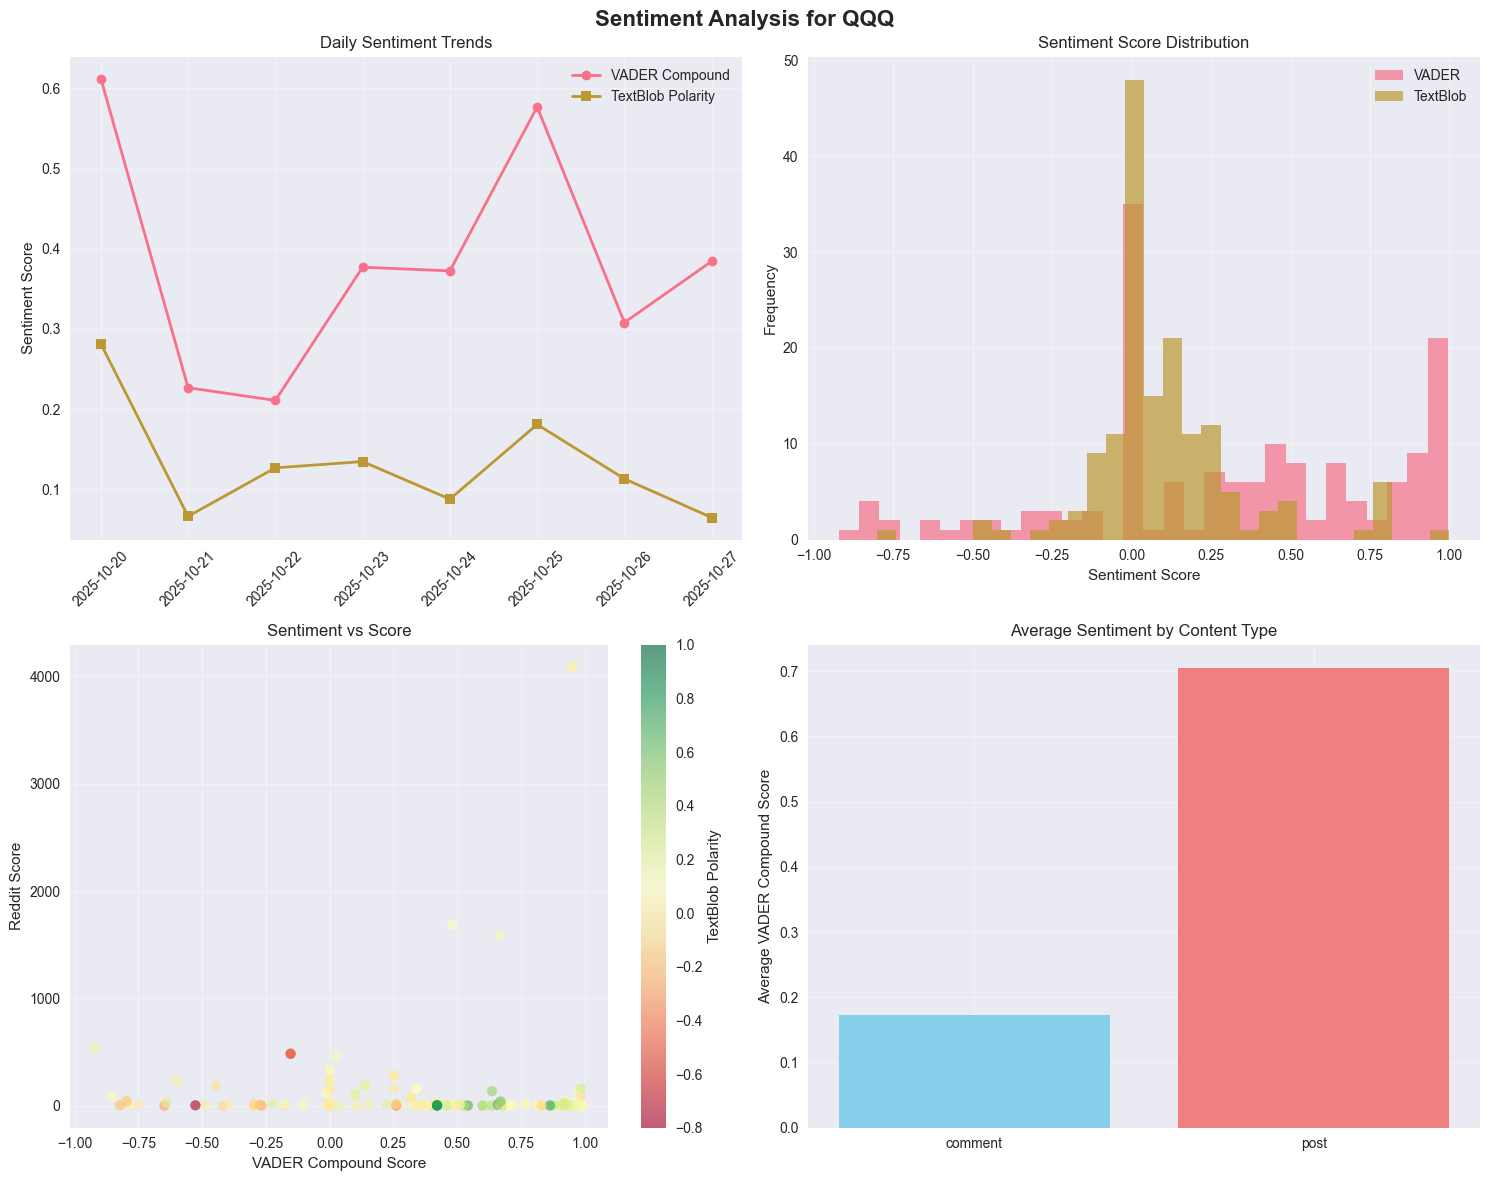


=== Sentiment Analysis Summary for QQQ ===
Total posts analyzed: 38
Total comments analyzed: 120
Average VADER compound score: 0.300
Average TextBlob polarity: 0.099
Sentiment standard deviation: 0.491

Sentiment Classification:
Positive: 96 (60.8%)
Neutral: 36 (22.8%)
Negative: 26 (16.5%)

=== Sample Posts ===
                                                                      title  vader_compound  textblob_polarity  score
                               Why is QQQ considered a subject to a bubble?          0.8196           0.038333      0
           Invesco Delays Proxy Vote on the Future of $400 Billion QQQ Fund          0.8399           0.153013      1
                             I made a spreadsheet to quickly find good buys          0.9753           0.129630    137
                         Market value, adjusted for the value of the dollar          0.6124           0.281481      2
AI is changing everything, But where are the real investment opportunities?          0.9956     

In [ ]:
# Analyze the collected QQQ data
if 'qqq_processed' in locals() and qqq_processed:
    qqq_analysis = analyze_sentiment_trends(qqq_processed)
    
    if qqq_analysis:
        plot_sentiment_analysis(qqq_analysis, 'QQQ')
        
        # Display sample of the data
        print("\n=== Sample Posts ===")
        sample_posts = qqq_processed['posts_df'][['title', 'vader_compound', 'textblob_polarity', 'score']].head()
        print(sample_posts.to_string(index=False))
        
        print("\n=== Sample Comments ===")
        sample_comments = qqq_processed['comments_df'][['body', 'vader_compound', 'textblob_polarity', 'score']].head()
        # Truncate long comments for display
        sample_comments['body'] = sample_comments['body'].str[:100] + '...'
        print(sample_comments.to_string(index=False))
else:
    print("No QQQ data available for analysis. Please run the data collection cell first.")


## Batch Collection for Multiple ETFs


In [ ]:
def collect_multiple_etfs(etf_symbols, posts_per_subreddit=10, comments_per_subreddit=15, time_filter='week'):
    """Collect data for multiple ETFs"""
    all_etf_data = {}
    
    for etf in etf_symbols:
        print(f"\n{'='*50}")
        print(f"Collecting data for {etf}")
        print(f"{'='*50}")
        
        etf_data = collect_etf_data(etf, posts_per_subreddit, comments_per_subreddit, time_filter)
        
        if etf_data:
            processed_data = process_etf_data(etf_data)
            if processed_data:
                all_etf_data[etf] = processed_data
                print(f"✓ Successfully processed {etf}")
            else:
                print(f"✗ Failed to process {etf}")
        else:
            print(f"✗ Failed to collect {etf}")
        
        # Rate limiting between ETFs
        time.sleep(2)
    
    return all_etf_data

def compare_etf_sentiment(all_etf_data):
    """Compare sentiment across multiple ETFs"""
    if not all_etf_data:
        print("No ETF data available for comparison")
        return
    
    comparison_data = []
    
    for etf, data in all_etf_data.items():
        if not data['posts_df'].empty or not data['comments_df'].empty:
            # Combine posts and comments
            all_text_data = []
            
            if not data['posts_df'].empty:
                posts_sentiment = data['posts_df'][['vader_compound', 'textblob_polarity']].copy()
                posts_sentiment['type'] = 'post'
                all_text_data.append(posts_sentiment)
            
            if not data['comments_df'].empty:
                comments_sentiment = data['comments_df'][['vader_compound', 'textblob_polarity']].copy()
                comments_sentiment['type'] = 'comment'
                all_text_data.append(comments_sentiment)
            
            if all_text_data:
                combined_sentiment = pd.concat(all_text_data, ignore_index=True)
                
                etf_summary = {
                    'ETF': etf,
                    'Sector': data['sector'],
                    'Total_Posts': len(data['posts_df']),
                    'Total_Comments': len(data['comments_df']),
                    'Avg_VADER_Compound': combined_sentiment['vader_compound'].mean(),
                    'Avg_TextBlob_Polarity': combined_sentiment['textblob_polarity'].mean(),
                    'Sentiment_Std': combined_sentiment['vader_compound'].std(),
                    'Positive_Ratio': (combined_sentiment['vader_compound'] > 0.05).mean(),
                    'Negative_Ratio': (combined_sentiment['vader_compound'] < -0.05).mean()
                }
                comparison_data.append(etf_summary)
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        
        # Create comparison visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('ETF Sentiment Comparison', fontsize=16, fontweight='bold')
        
        # Plot 1: Average sentiment by ETF
        axes[0, 0].bar(comparison_df['ETF'], comparison_df['Avg_VADER_Compound'], 
                      color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
        axes[0, 0].set_title('Average VADER Compound Score by ETF')
        axes[0, 0].set_ylabel('Sentiment Score')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Sentiment distribution by sector
        sector_sentiment = comparison_df.groupby('Sector')['Avg_VADER_Compound'].mean()
        axes[0, 1].bar(sector_sentiment.index, sector_sentiment.values, 
                      color=['lightblue', 'lightgreen', 'lightcoral', 'gold'])
        axes[0, 1].set_title('Average Sentiment by Sector')
        axes[0, 1].set_ylabel('Sentiment Score')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Positive vs Negative ratio
        x = np.arange(len(comparison_df))
        width = 0.35
        axes[1, 0].bar(x - width/2, comparison_df['Positive_Ratio'], width, 
                      label='Positive', color='lightgreen')
        axes[1, 0].bar(x + width/2, comparison_df['Negative_Ratio'], width, 
                      label='Negative', color='lightcoral')
        axes[1, 0].set_title('Positive vs Negative Sentiment Ratio')
        axes[1, 0].set_ylabel('Ratio')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(comparison_df['ETF'], rotation=45)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Data volume by ETF
        total_volume = comparison_df['Total_Posts'] + comparison_df['Total_Comments']
        axes[1, 1].bar(comparison_df['ETF'], total_volume, 
                      color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
        axes[1, 1].set_title('Total Data Volume by ETF')
        axes[1, 1].set_ylabel('Number of Posts + Comments')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Display comparison table
        print("\n=== ETF Sentiment Comparison Table ===")
        display_cols = ['ETF', 'Sector', 'Total_Posts', 'Total_Comments', 
                       'Avg_VADER_Compound', 'Positive_Ratio', 'Negative_Ratio']
        print(comparison_df[display_cols].round(3).to_string(index=False))
        
        return comparison_df
    
    return None

print("Batch collection and comparison functions defined successfully!")


Batch collection and comparison functions defined successfully!


## Example: Collect Data for All ETFs


In [ ]:
# Collect data for all configured ETFs (this will take some time)
etf_symbols = ['QQQ', 'DIA', 'IWM', 'EFA', 'VTI']

print("Starting batch collection for all ETFs...")
print("This may take several minutes due to rate limiting...")

all_etf_data = collect_multiple_etfs(
    etf_symbols, 
    posts_per_subreddit=8,  # Reduced to avoid rate limits
    comments_per_subreddit=12,  # Reduced to avoid rate limits
    time_filter='week'
)

print(f"\nBatch collection completed!")
print(f"Successfully collected data for {len(all_etf_data)} ETFs: {list(all_etf_data.keys())}")


Starting batch collection for all ETFs...
This may take several minutes due to rate limiting...

  Searching for keyword: QQQ
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Searching for keyword: NASDAQ
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Searching for keyword: tech stocks
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Collected 35 posts and 72 comments for QQQ
✓ Successfully processed QQQ

  Searching for keyword: DIA
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Searching for keyword: Dow Jones
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Searching for keyword: industrial
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Collected 17 posts and 34 comments for DIA
✓ Successfully processed DIA

  Searching for keyword: IW

## Compare All ETFs


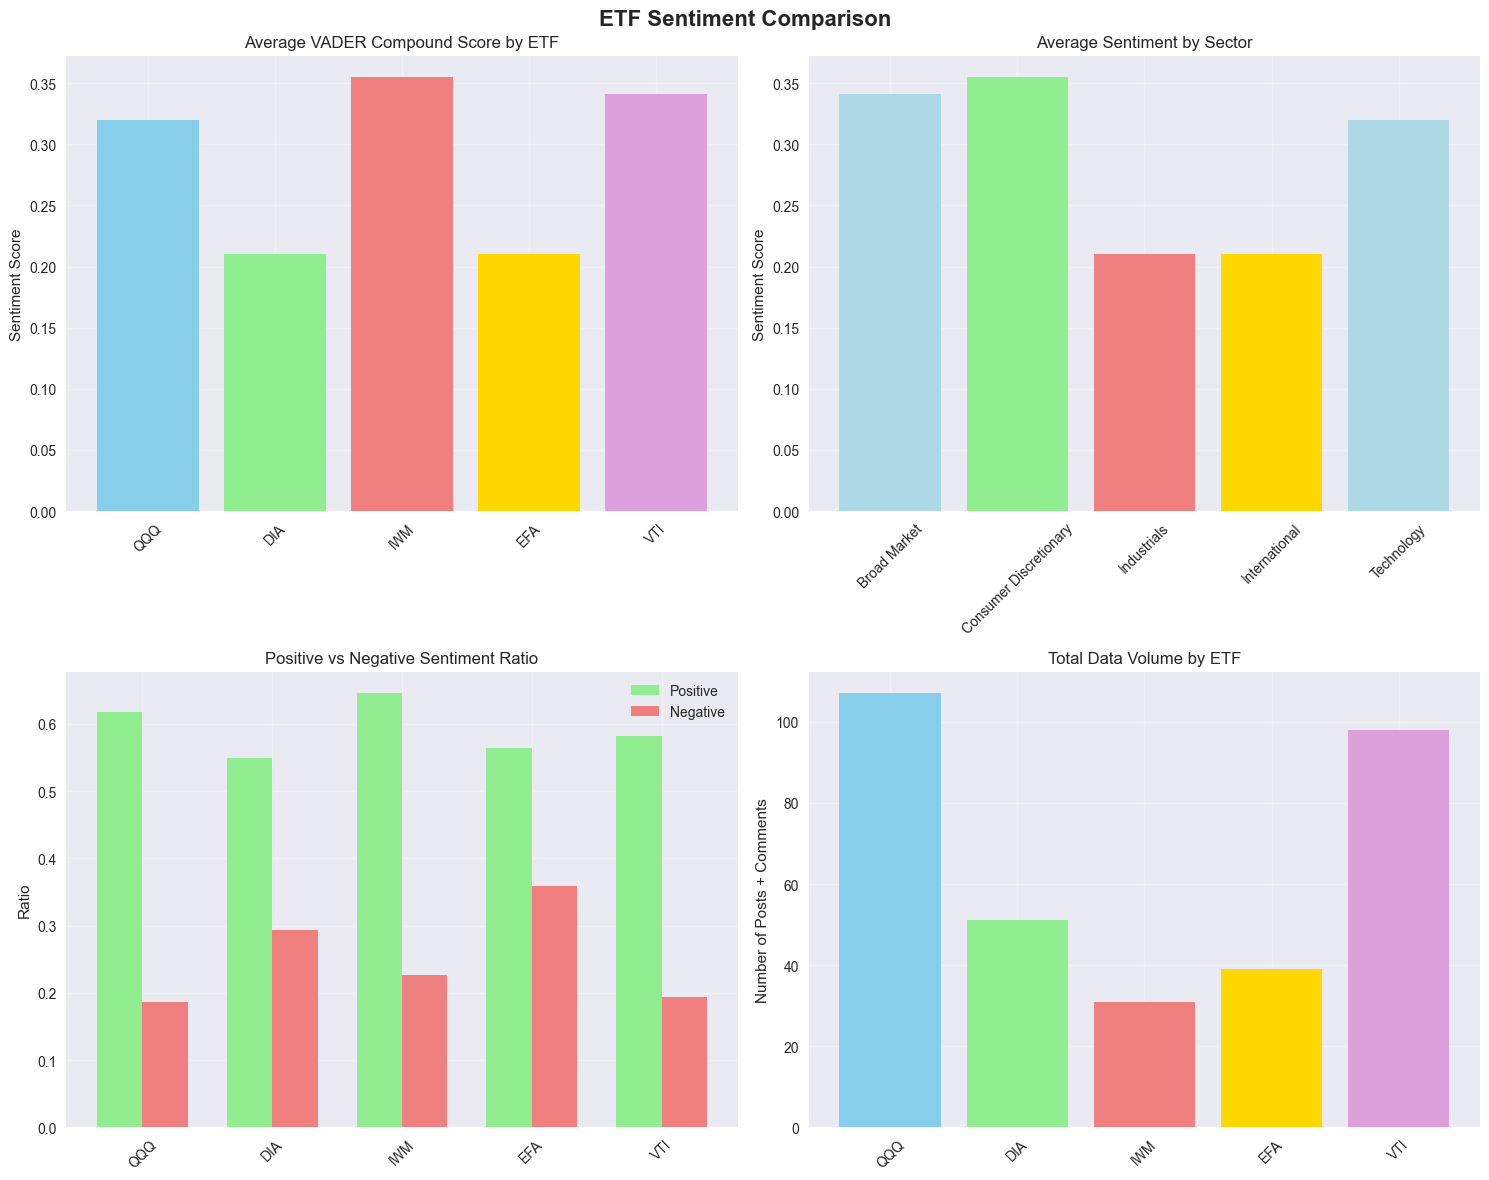


=== ETF Sentiment Comparison Table ===
ETF                 Sector  Total_Posts  Total_Comments  Avg_VADER_Compound  Positive_Ratio  Negative_Ratio
QQQ             Technology           35              72               0.319           0.617           0.187
DIA            Industrials           17              34               0.211           0.549           0.294
IWM Consumer Discretionary            9              22               0.355           0.645           0.226
EFA          International           15              24               0.211           0.564           0.359
VTI           Broad Market           31              67               0.341           0.582           0.194

=== Key Insights ===
Most Positive Sentiment: IWM (Consumer Discretionary) - Score: 0.355
Most Negative Sentiment: EFA (International) - Score: 0.211

Sector Sentiment Ranking:
  Consumer Discretionary: 0.355
  Broad Market: 0.341
  Technology: 0.319
  Industrials: 0.211
  International: 0.211


In [ ]:
# Compare sentiment across all collected ETFs
if all_etf_data:
    comparison_results = compare_etf_sentiment(all_etf_data)
    
    if comparison_results is not None:
        print("\n=== Key Insights ===")
        
        # Find most positive and negative ETFs
        most_positive = comparison_results.loc[comparison_results['Avg_VADER_Compound'].idxmax()]
        most_negative = comparison_results.loc[comparison_results['Avg_VADER_Compound'].idxmin()]
        
        print(f"Most Positive Sentiment: {most_positive['ETF']} ({most_positive['Sector']}) - Score: {most_positive['Avg_VADER_Compound']:.3f}")
        print(f"Most Negative Sentiment: {most_negative['ETF']} ({most_negative['Sector']}) - Score: {most_negative['Avg_VADER_Compound']:.3f}")
        
        # Find sector with highest sentiment
        sector_avg = comparison_results.groupby('Sector')['Avg_VADER_Compound'].mean().sort_values(ascending=False)
        print(f"\nSector Sentiment Ranking:")
        for sector, score in sector_avg.items():
            print(f"  {sector}: {score:.3f}")
else:
    print("No ETF data available for comparison. Please run the batch collection cell first.")


## Data Export and Saving


In [ ]:
def save_etf_data(all_etf_data, filename_prefix="reddit_sentiment_data"):
    """Save collected ETF data to CSV files"""
    if not all_etf_data:
        print("No data to save")
        return
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    for etf, data in all_etf_data.items():
        # Save posts data
        if not data['posts_df'].empty:
            posts_filename = f"{filename_prefix}_{etf}_posts_{timestamp}.csv"
            data['posts_df'].to_csv(posts_filename, index=False)
            print(f"Saved {len(data['posts_df'])} posts for {etf} to {posts_filename}")
        
        # Save comments data
        if not data['comments_df'].empty:
            comments_filename = f"{filename_prefix}_{etf}_comments_{timestamp}.csv"
            data['comments_df'].to_csv(comments_filename, index=False)
            print(f"Saved {len(data['comments_df'])} comments for {etf} to {comments_filename}")
    
    # Save comparison summary
    if 'comparison_results' in locals() and comparison_results is not None:
        summary_filename = f"{filename_prefix}_comparison_{timestamp}.csv"
        comparison_results.to_csv(summary_filename, index=False)
        print(f"Saved comparison summary to {summary_filename}")

# Save the data (uncomment to save)
# save_etf_data(all_etf_data)

print("Data saving function defined. Uncomment the save_etf_data() call to save your data.")


Data saving function defined. Uncomment the save_etf_data() call to save your data.


In [ ]:
# Export QQQ sentiment data to CSV files
if 'qqq_processed' in locals() and qqq_processed:
    from datetime import datetime
    
    # Create timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Export posts data
    if not qqq_processed['posts_df'].empty:
        posts_filename = f"QQQ_posts_sentiment_{timestamp}.csv"
        qqq_processed['posts_df'].to_csv(posts_filename, index=False)
        print(f"✓ Saved {len(qqq_processed['posts_df'])} QQQ posts to: {posts_filename}")
        
        # Show sample of what was saved
        print(f"\nSample of saved posts data:")
        print(qqq_processed['posts_df'][['title', 'vader_compound', 'textblob_polarity', 'score', 'created_utc']].head(3).to_string(index=False))
    
    # Export comments data
    if not qqq_processed['comments_df'].empty:
        comments_filename = f"QQQ_comments_sentiment_{timestamp}.csv"
        qqq_processed['comments_df'].to_csv(comments_filename, index=False)
        print(f"✓ Saved {len(qqq_processed['comments_df'])} QQQ comments to: {comments_filename}")
        
        # Show sample of what was saved
        print(f"\nSample of saved comments data:")
        sample_comments = qqq_processed['comments_df'][['body', 'vader_compound', 'textblob_polarity', 'score', 'created_utc']].head(3).copy()
        sample_comments['body'] = sample_comments['body'].str[:50] + '...'  # Truncate for display
        print(sample_comments.to_string(index=False))
    
    # Create a summary CSV with key metrics
    if 'qqq_analysis' in locals() and qqq_analysis:
        summary_data = {
            'ETF': ['QQQ'],
            'Total_Posts': [len(qqq_processed['posts_df'])],
            'Total_Comments': [len(qqq_processed['comments_df'])],
            'Avg_VADER_Compound': [qqq_analysis['combined_data']['vader_compound'].mean()],
            'Avg_TextBlob_Polarity': [qqq_analysis['combined_data']['textblob_polarity'].mean()],
            'Sentiment_Std': [qqq_analysis['combined_data']['vader_compound'].std()],
            'Positive_Ratio': [(qqq_analysis['combined_data']['vader_compound'] > 0.05).mean()],
            'Negative_Ratio': [(qqq_analysis['combined_data']['vader_compound'] < -0.05).mean()],
            'Data_Collection_Date': [datetime.now().strftime("%Y-%m-%d %H:%M:%S")]
        }
        
        summary_df = pd.DataFrame(summary_data)
        summary_filename = f"QQQ_sentiment_summary_{timestamp}.csv"
        summary_df.to_csv(summary_filename, index=False)
        print(f"✓ Saved QQQ sentiment summary to: {summary_filename}")
        print(f"\nSummary data:")
        print(summary_df.to_string(index=False))
    
    print(f"\n🎉 All QQQ sentiment data exported successfully!")
    print(f"Files created in your current directory:")
    print(f"- {posts_filename if not qqq_processed['posts_df'].empty else 'No posts data'}")
    print(f"- {comments_filename if not qqq_processed['comments_df'].empty else 'No comments data'}")
    print(f"- {summary_filename if 'qqq_analysis' in locals() else 'No summary data'}")

else:
    print("❌ No QQQ data available to export.")
    print("Please run the QQQ data collection cell first to scrape and process the data.")


✓ Saved 38 QQQ posts to: QQQ_posts_sentiment_20251027_183945.csv

Sample of saved posts data:
                                                           title  vader_compound  textblob_polarity  score         created_utc
                    Why is QQQ considered a subject to a bubble?          0.8196           0.038333      0 2025-10-24 21:41:41
Invesco Delays Proxy Vote on the Future of $400 Billion QQQ Fund          0.8399           0.153013      1 2025-10-24 18:55:49
                  I made a spreadsheet to quickly find good buys          0.9753           0.129630    137 2025-10-26 09:02:18
✓ Saved 120 QQQ comments to: QQQ_comments_sentiment_20251027_183945.csv

Sample of saved comments data:
                                                 body  vader_compound  textblob_polarity  score         created_utc
  Because people are always fighting the last war....         -0.7506           0.000000     10 2025-10-24 21:45:24
I guess you missed where it took QQQ 16 years to b...         

## Next Steps and Recommendations

### 1. **Data Quality Improvements**
- Implement more sophisticated text preprocessing
- Add domain-specific sentiment lexicons for financial terms
- Filter out spam and low-quality content

### 2. **Advanced Analysis**
- Implement time series analysis to predict ETF movements
- Add correlation analysis between sentiment and actual ETF prices
- Implement machine learning models for sentiment classification

### 3. **Real-time Monitoring**
- Set up automated data collection scripts
- Implement alerting for significant sentiment changes
- Create dashboards for real-time monitoring

### 4. **Integration with Market Data**
- Combine with actual ETF price data from your CSV files
- Implement backtesting strategies based on sentiment signals
- Add technical indicators to sentiment analysis

### 5. **Rate Limiting and Optimization**
- Implement more sophisticated rate limiting
- Use Reddit's pushshift API for historical data
- Consider using multiple Reddit accounts for higher limits

### 6. **Additional Data Sources**
- Integrate with other social media platforms
- Add news sentiment analysis
- Include analyst reports and earnings calls

---

**Note**: Remember to be respectful of Reddit's API terms of service and implement proper rate limiting. The free tier has limitations, so consider upgrading if you need higher data volumes.
